This notebook is based on

https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html

# Bayesian GLMs in PyMC

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Generating data

Essentially we are creating a regression line defined by intercept and slope and add data points by sampling from a Normal with the mean set to the regression line.

In [3]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

data = pd.DataFrame(dict(x=x, y=y))

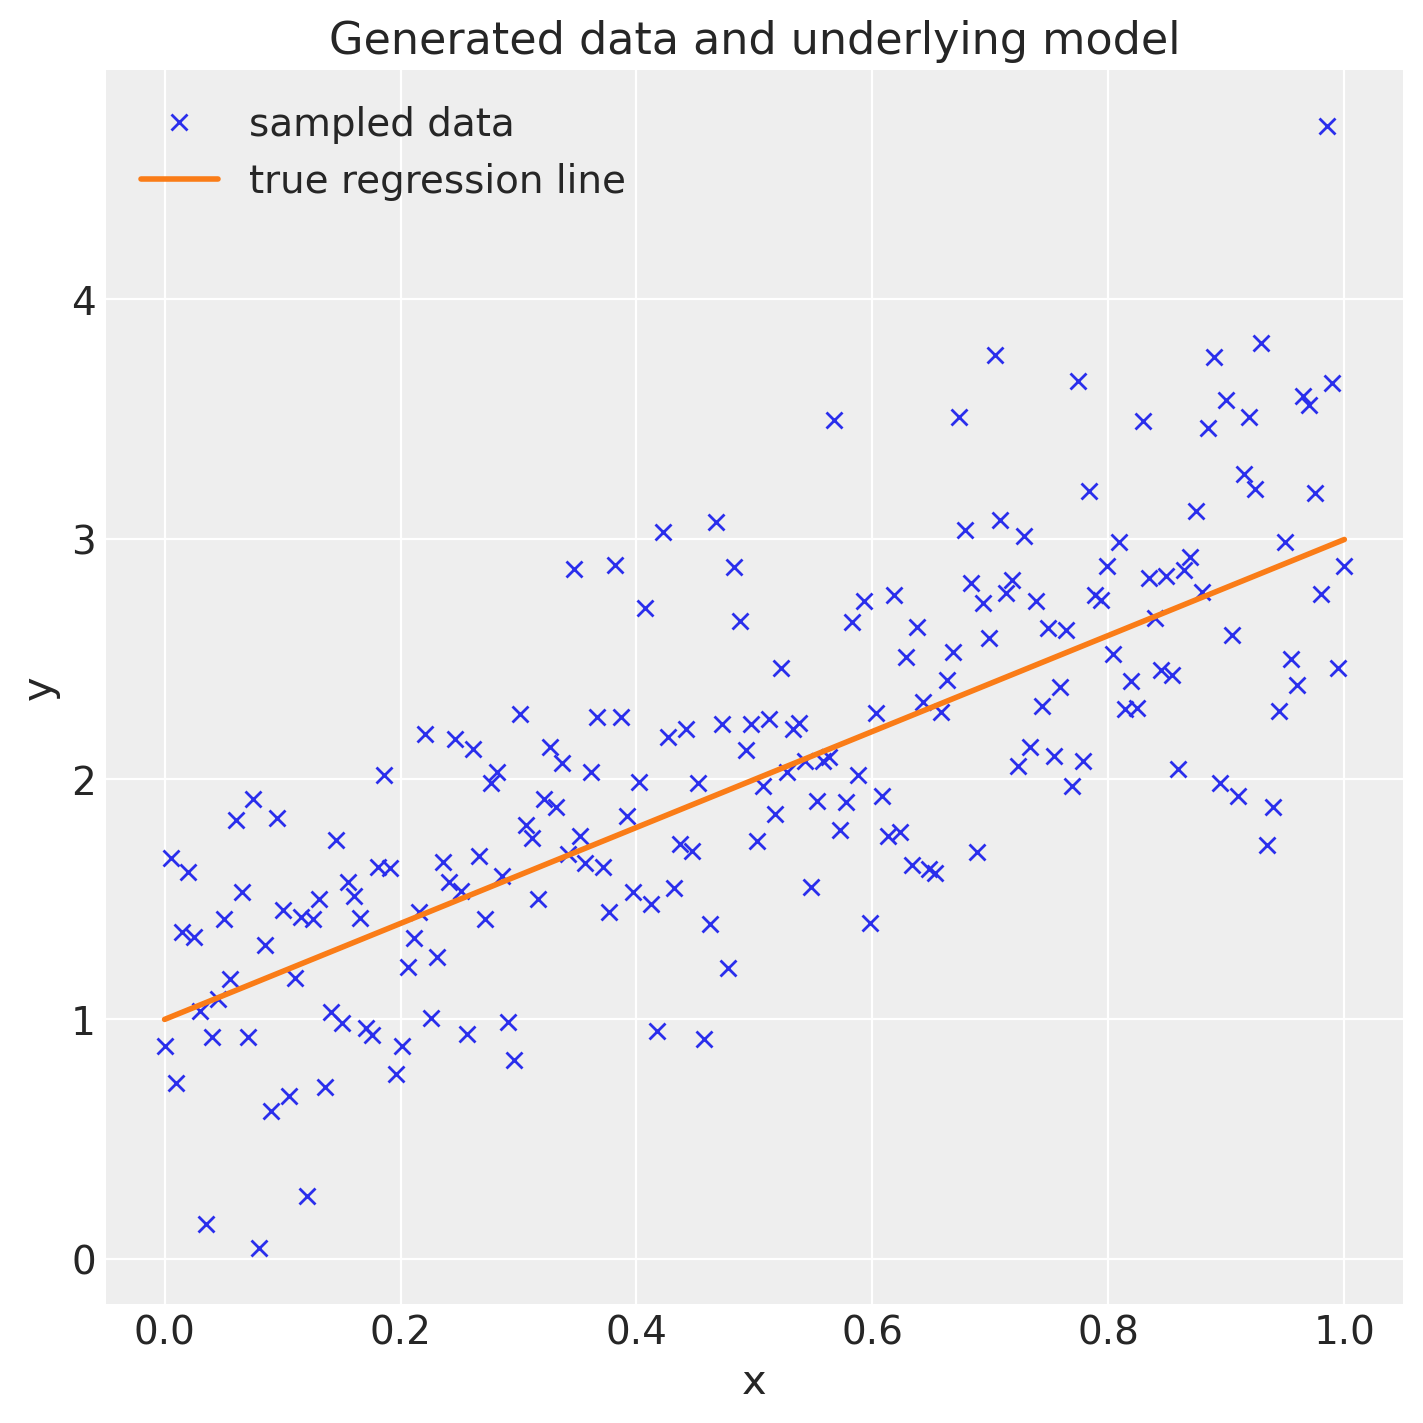

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

## Estimating the model

Lets fit a Bayesian linear regression model to this data. In PyMC, the model specifications takes place in a with expression, called a context manager. By default, models are fit using the NUTS sampler, resulting in a trace of samples representing the marginal posterior distribution of the latent model parameters.

In [9]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = HalfCauchy("sigma", beta=10)
    intercept = Normal("Intercept", 0, sigma=20)
    slope = Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.


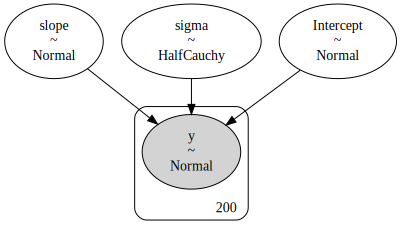

In [10]:
pm.model_to_graphviz(model)

This should be fairly readable for people who know probabilistic programming. However, would a non-statistican know what all this does? Moreover, recall that this is an extremely simple model that would be one line in R. Having multiple, potentially transformed regressors, interaction terms or link-functions would also make this much more complex and error prone.

To make things even simpler, the [bambi](https://bambinos.github.io/bambi/) library takes a [formula](https://bambinos.github.io/formulae/) linear model specifier from which it creates a design matrix. bambi then adds random variables for each of the coefficients and an appropriate likelihood to the model.

If bambi is not installed, you can install it with pip install bambi.

In [6]:
import sys

try:
    import bambi as bmb
except ImportError:
    !{sys.executable} -m pip install -q --upgrade bambi
    import bambi as bmb

In [11]:
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, x]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


Much shorter, but this code does the exact same thing as the previous specification (you can change priors and everything else too if we wanted). bambi parses the formulae model string, adds random variables for each regressor (Intercept and slope x in this case), adds a likelihood (by default, a Normal is chosen), and all other variables (sigma). Finally, bambi then initializes the parameters to a good starting point by estimating a frequentist linear model using statsmodels.

If you are not familiar with R’s syntax, 'y ~ x' specifies that we have an output variable y that we want to estimate as a linear function of x.

In [13]:
# SRM: Tried to visualise the model generated by bmb but it fails
# with AttributeError: 'Model' object has no attribute 'named_vars'
#
# pm.model_to_graphviz(model)

## Analyzing the model

Bayesian inference does not give us only one line of best fit (as maximum likelihood does) but rather a whole posterior distribution of plausible parameters. Lets plot the posterior distribution of our parameters and the individual samples we drew.

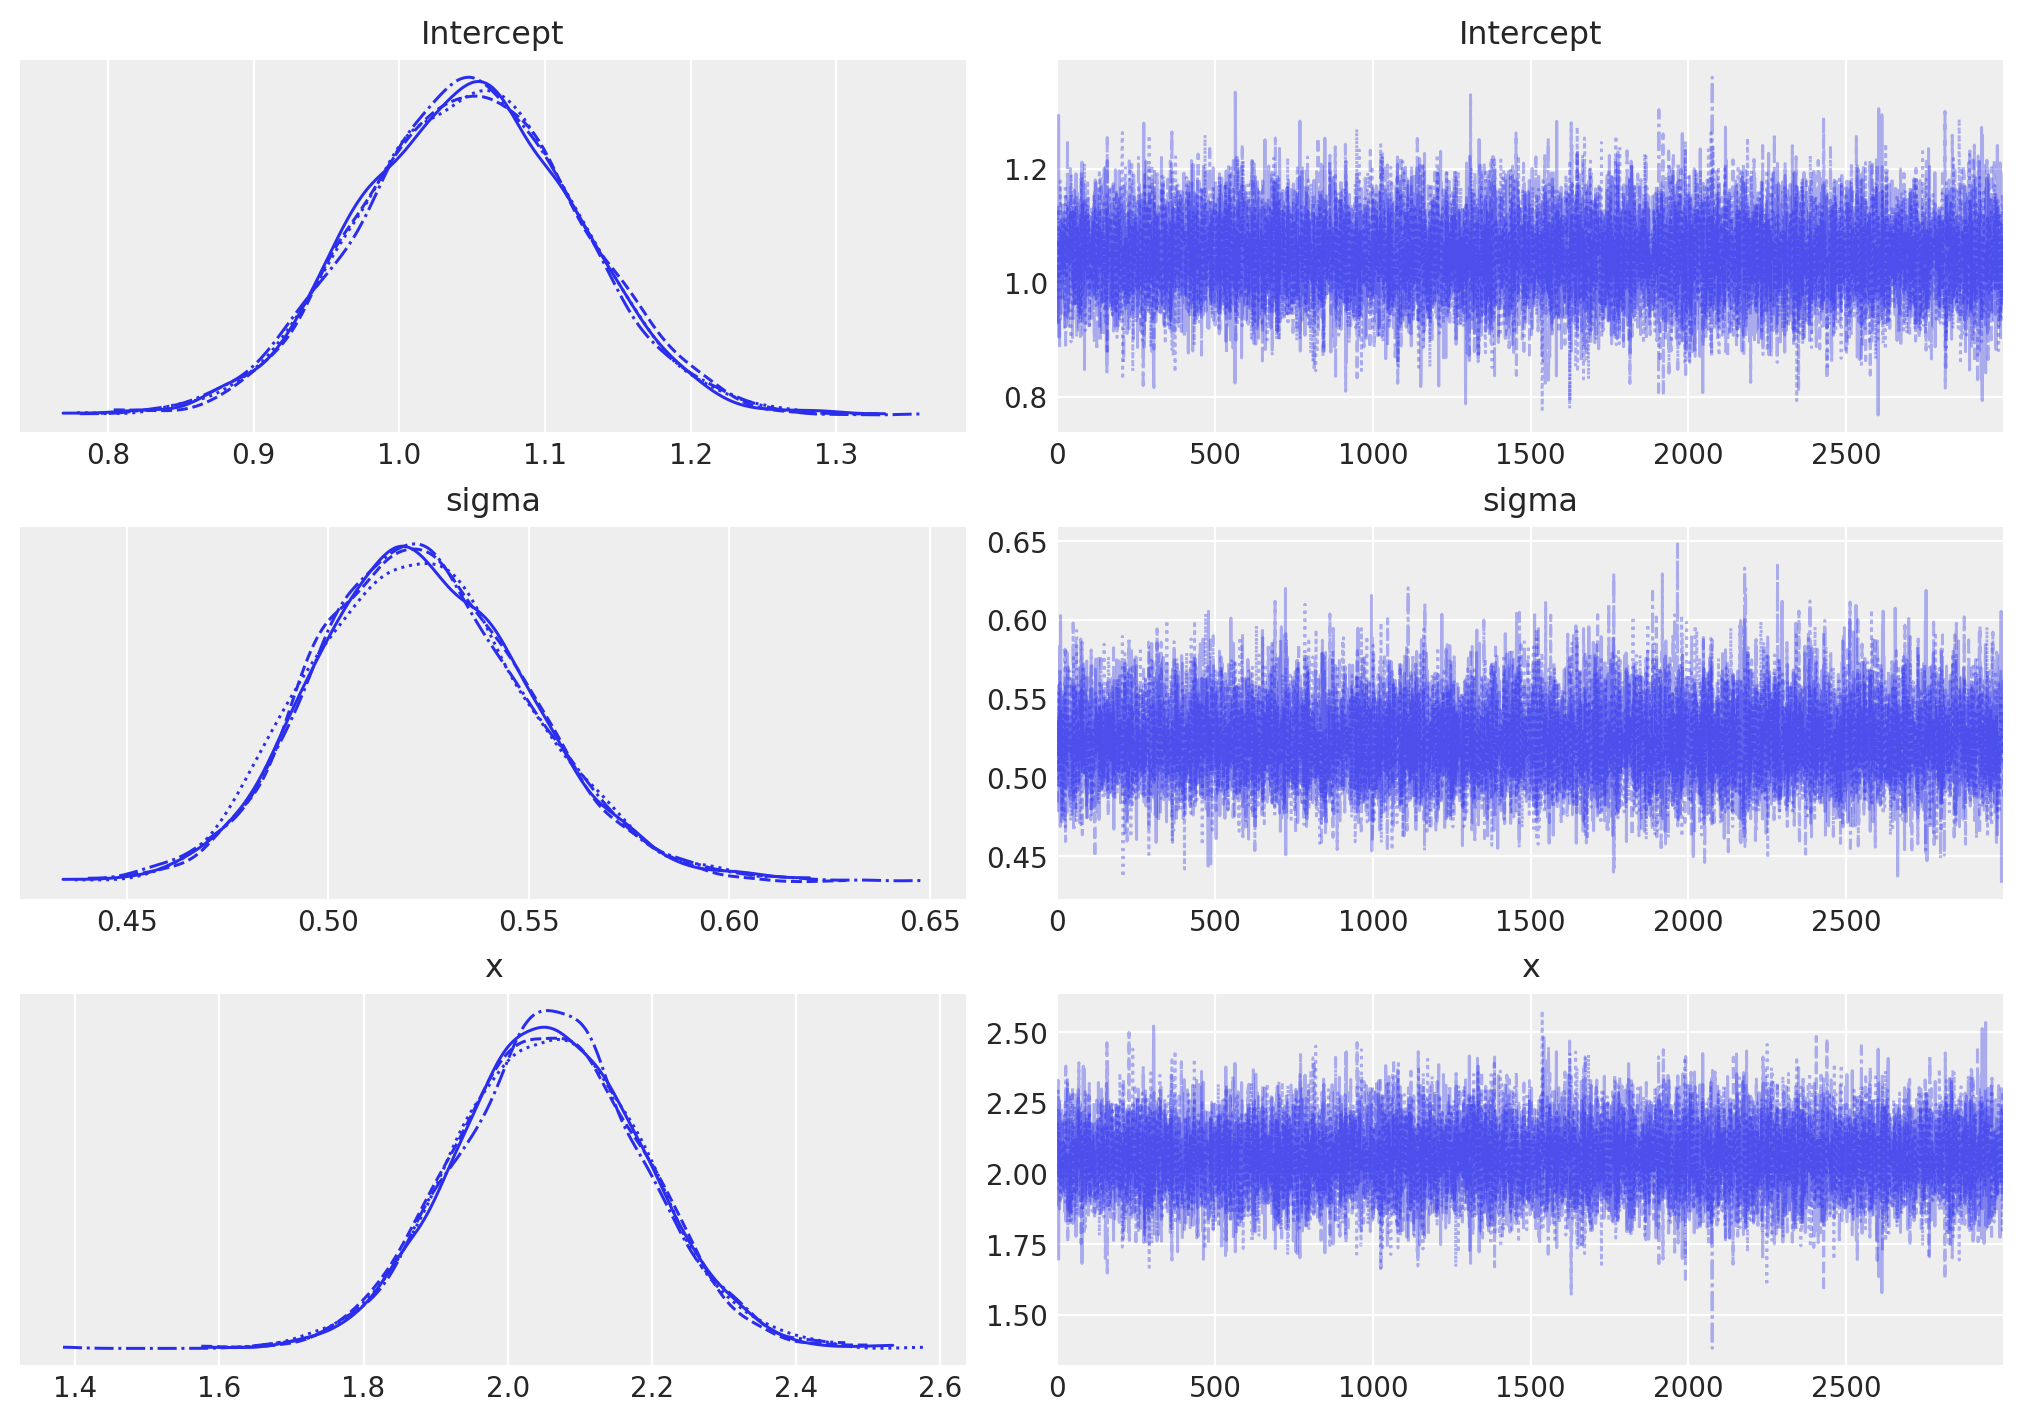

In [14]:
az.plot_trace(idata, figsize=(10, 7));

The left side shows our marginal posterior – for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem homogeneous and stationary (there are no large drifts or other odd patterns).

Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (x is the regression coefficient and sigma is the standard deviation of our normal).

In GLMs, we thus do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. We can manually generate these regression lines using the posterior samples directly.

In [15]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["x"] * xr.DataArray(x)

/home/reza/miniconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/plots/lmplot.py:212: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


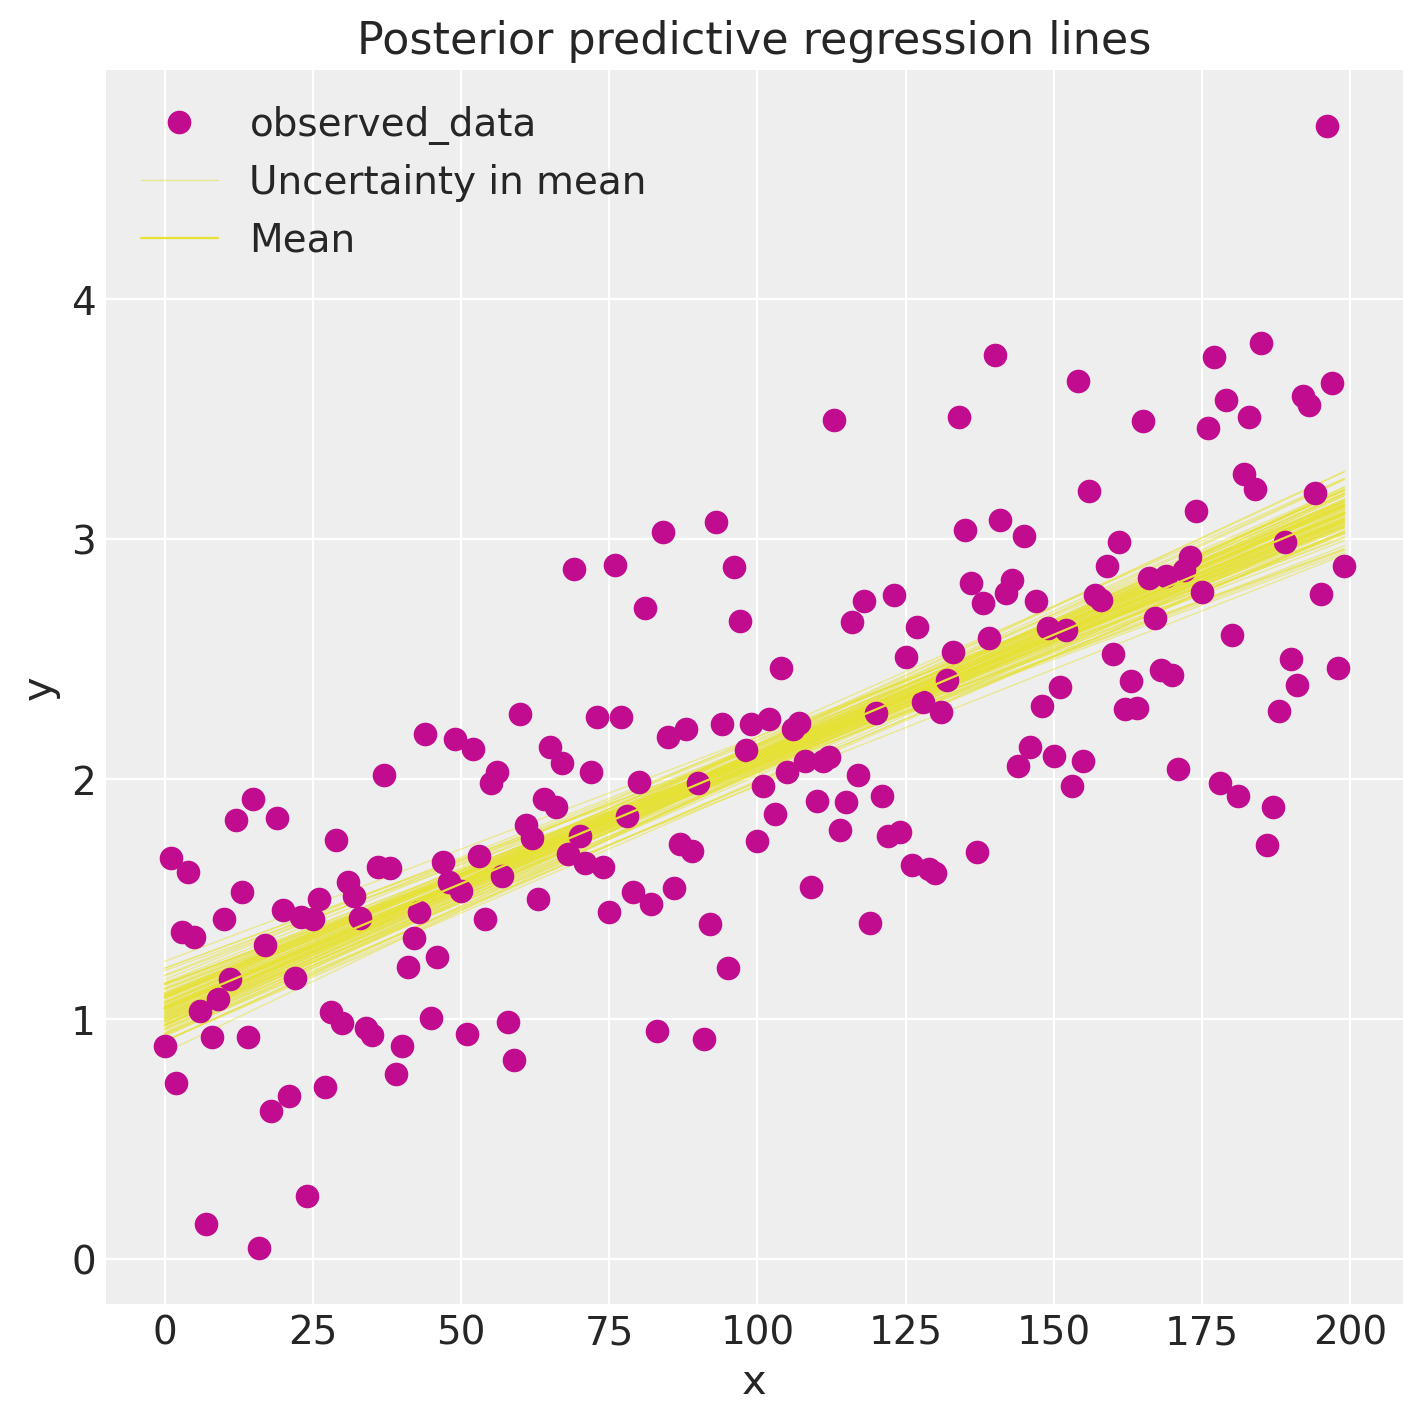

In [16]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");

As you can see, our estimated regression lines are very similar to the true regression line. But since we only have limited data we have uncertainty in our estimates, here expressed by the variability of the lines.

In [17]:
%load_ext watermark

%watermark -n -u -v -iv -w -p pytensor

Last updated: Tue Sep 03 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

pytensor: 2.25.4

matplotlib: 3.9.2
numpy     : 1.26.4
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
arviz     : 0.19.0
xarray    : 2024.7.0
bambi     : 0.14.0
pymc      : 5.16.2
pandas    : 2.2.2

Watermark: 2.4.3

